In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats

En este cuaderno se analizan los datos de Presión atmosférica, Humedad relativa y Temperatura ambiental del laboratorio de balanzas del DMQ con el fin de determinar un valor de densidad del aire que permita ser utilizado para realizar cálculos. Todas las constantes y funciones implementadas provienen del artículo *Revised formula for the density of moist air (CIPM-2007)* de A Picard, R S Davis, M Gläser y K Fujii del $2008$, este se puede visitar en https://www.nist.gov/system/files/documents/calibrations/CIPM-2007.pdf.

La constante de los gases ideales $R$ se tomó de https://physics.nist.gov/cgi-bin/cuu/Value?r|search_for=R, pues es el valor más actualizado.

In [2]:
filedir="Datos/CondicionesAmbientalesBalanzas" # directorio general
años=os.listdir(filedir) # lista de carpetas en el directorio

In [3]:
data=np.array([0,0,0]).reshape((1,3)) # arreglo inicial para poder añadir cada archivo
for año in años: # loop por año
    añodir=os.path.join(filedir,año) # unión de directorio general y carpeta
    añolist=os.listdir(añodir) # lista de archivos del año
    for iArchivo in añolist: # loop de archivos
        data=np.append(data,np.loadtxt(os.path.join(añodir,iArchivo),usecols=(2,4,6)),axis=0) # lectura y unión de arreglos

In [4]:
data=data[np.all(data != 0, axis=1)] # se descartan filas con valores de 0

In [13]:
data.shape

(971228, 3)

In [6]:
def Psv(T):
    '''
    Función que calcula la presión de vapor de saturación siguiendo la fórmula que se presenta en el artículo de referencia.
    Input:
    -------------
    T: temperatura en °C.
    
    Output:
    -------------
    Psv: valor de la presión de vapor de saturación en hPa.
    '''
    A=0.000012378847
    B=-0.019121316
    C=33.93711047
    D=-6343.1645
    return np.exp(A*(T+273.15)**2+B*(T+273.15)+C+D/(T+273.15))/100

In [7]:
def f(P,T):
    '''
    Función que calcula el factor de fugasidad siguiendo la ecuación de la referencia.
    
    Input:
    --------------
    P: presión en Pa.
    T: temperatura en °C.
    
    Output:
    --------------
    f: Valor del coeficiente de fugacidad.
    '''
    alpha=1.00062
    beta=0.0000000314
    gamma=0.00000056
    return alpha+beta*P/100+gamma*T**2

In [8]:
def xv(Hr,P,T):
    '''
    Función que calcula la fracción molar de vapor de agua siguiendo el artículo de referencia.
    
    Input:
    ---------------
    Hr: humedad relativa como un valor entre 0 y 1.
    P: presión atmosférica en Pa.
    T: Temperatura en °C.
    
    Output:
    ---------------
    xv: Valor de la fracción molar de vapor de agua.
    '''
    return Hr*f(P,T)*Psv(T)/P/100

In [9]:
def Z(P,Hr,T):
    '''
    Función que calcula el factor de compresibilidad con la ecuación del artículo de referencia.
    
    Input:
    --------------
    P: Presión atmosférica en Pa.
    Hr: Humedad relativa como un valor entre 0 y 1.
    T: Temperatura en °C.
    
    Output:
    ---------------
    Z: factor de compresibilidad.
    '''
    a0=1.58123e-6
    a1=-2.9331e-8
    a2=1.1043e-10
    b0=5.703e-6
    b1=-2.051e-8
    c0=1.9898e-4
    c1=-2.376e-6
    d=1.83e-11
    e=-7.65e-9
    # T+=273.15
    # P/=100
    return 1-(P/100)/(T+273.15)*(a0+a1*T+a2*T**2+(b0+b1*T)*xv(Hr,P,T)+(c0+c1*T)*xv(Hr,P,T)**2)+(P/100)**2/(T+273.15)**2*(d+e*xv(Hr,P,T)**2)

In [10]:
def DensidadCIPM(P,Hr,T):
    '''
    Función que calcula la densidad del aire a partir de la ecuación del artículo de referencia.
    
    Input:
    --------------
    P: Presión atmosférica en Pa.
    Hr: Humedad relativa como un valor entre 0 y 1.
    T: Temperatura en °C.
    
    Output:
    DensidadCIPM: densidad del aire en kg/m^3.
    '''
    Ma=0.02896546
    Mv=0.018015
    R=8.314462618
    # print(f(P,T))
    # print(Z(P,Hr,T))
    # print(xv(Hr,P,T))
    # print(Psv(T))
    return (Ma*P+(Mv-Ma)*Hr*f(P,T)*Psv(T))/(Z(P,Hr,T)*R*(T+273.15))

In [11]:
densidades=DensidadCIPM(data[1:,2].copy()*100,data[1:,1].copy()/100,data[1:,0].copy()) # Se evalúa la densidad para cada conjunto de tres datos

In [12]:
densidades.shape

(971227,)

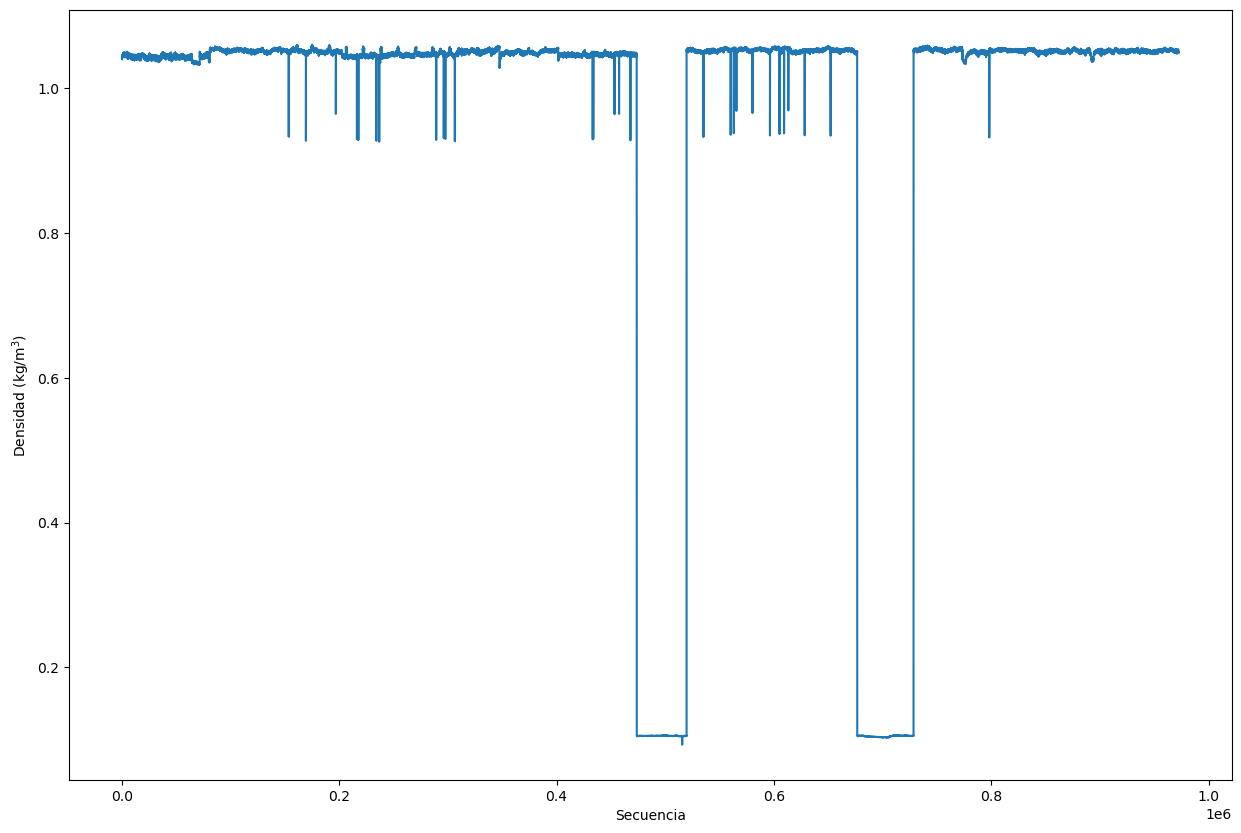

In [12]:
# Se realiza una gráfica en función del tiempo
plt.figure(figsize=(15,10))
plt.plot(densidades)
plt.xlabel("Secuencia")
plt.ylabel(r"Densidad (kg/m$^3$)")
plt.show()

In [13]:
densidades=densidades[np.where(densidades>1)] # Se toman las densidad mayores a 1

In [14]:
# np.savetxt("DatosDensidades.csv", densidades, delimiter=",")

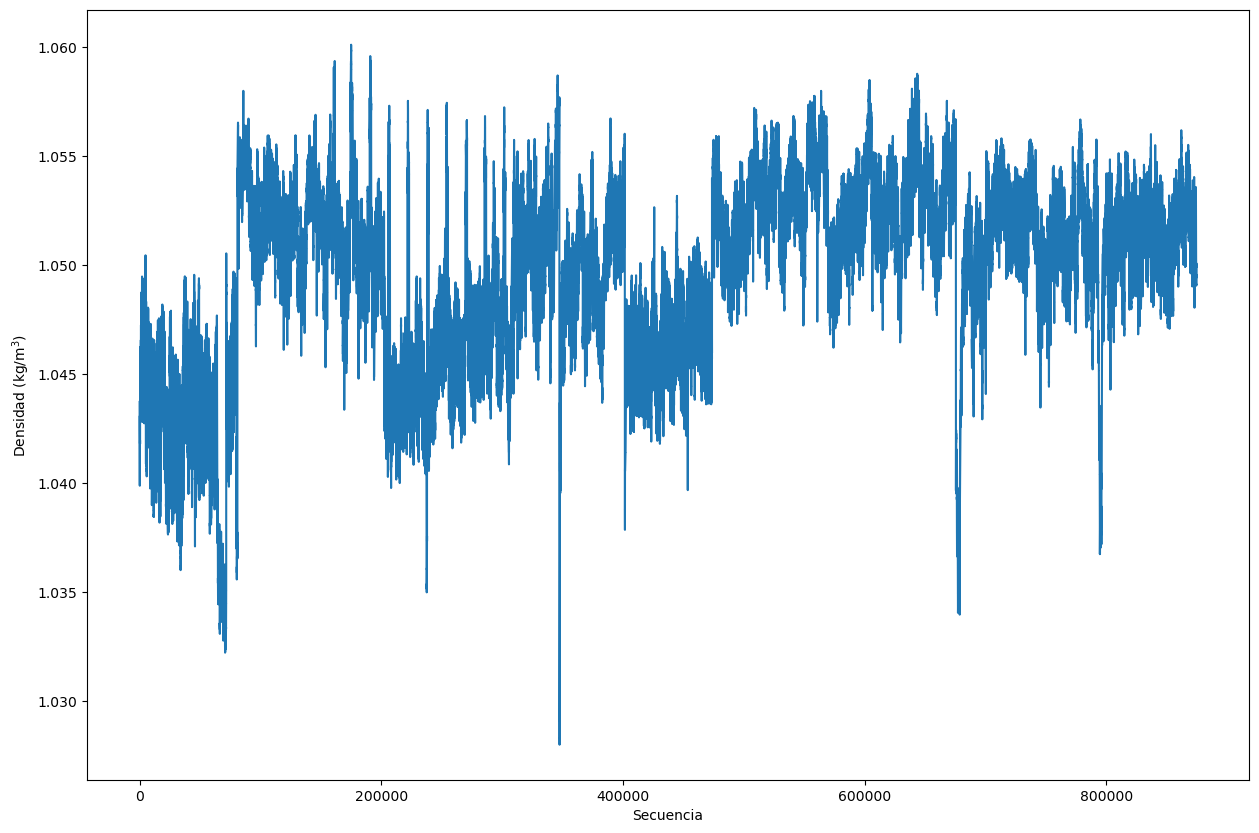

In [15]:
# Se realiza una gráfica en función del tiempo
plt.figure(figsize=(15,10))
plt.plot(densidades)
plt.xlabel("Secuencia")
plt.ylabel(r"Densidad (kg/m$^3$)")
plt.show()

In [16]:
# Histograma
plt.figure(figsize=(15/2,10/2))
plt.hist(densidades,density=True,bins=200)
plt.xlabel(r"Densidad (kg/m$^3$)")
plt.show()

Como la distribución no es normal, sino que es bimodal, se tomará como medida de tendencia central la mediana y como medida de disperción la desviación estandarizada absoluta con respecto a la mediana.

In [17]:
np.median(densidades) # se extrae la mediana

1.0506913974930663

In [18]:
made=1.4826*np.median(np.abs(densidades-np.median(densidades)))/np.sqrt(len(densidades)) # se calcula el MADe
made

4.083989990548195e-06

In [19]:
u=np.sqrt(9.56e-5**2+made**2)
u*2

0.0001913743867317975

La densidad del aire se puede reportar como $\left(1.050\,69\pm0.000\,19\right)\textrm{ kg/m}^3$ o $\left(0.001\,050\,69\pm0.000\,000\,19\right)\textrm{ g/cm}^3$.